In [36]:
# ===============================
# 1. Imports
# ===============================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


In [37]:
# ===============================
# 2. Paths & Parameters
# ===============================
male_folder   = r"C:\Users\TechMatched PC\img processing\crop\male"
female_folder = r"C:\Users\TechMatched PC\img processing\crop\female"

IMG_SIZE = (100, 100)
N_COMPONENTS = 100
RANDOM_STATE = 42


In [38]:
# ===============================
# 3. Load & Preprocess Images
# ===============================
def load_images(folder, label):
    images, labels = [], []

    for file in os.listdir(folder):
        if file.lower().endswith((".jpg", ".png")):
            path = os.path.join(folder, file)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                continue

            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0          # normalize
            images.append(img.flatten())
            labels.append(label)

    return images, labels


male_X, male_y = load_images(male_folder, 0)
female_X, female_y = load_images(female_folder, 1)

X = np.array(male_X + female_X)
y = np.array(male_y + female_y)

print("Total images:", X.shape[0])
print("Image vector size:", X.shape[1])


Total images: 3807
Image vector size: 10000


In [15]:
# ===============================
# 4. Train / Test Split (FIRST)
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)


In [39]:
# ===============================
# 5. Center Data (TRAIN MEAN ONLY)
# ===============================
mean_face = X_train.mean(axis=0)

X_train_c = X_train - mean_face
X_test_c  = X_test  - mean_face


In [40]:
# ===============================
# 6. PCA (Eigenfaces)
# ===============================
pca = PCA(
    n_components=N_COMPONENTS,
    whiten=True,
    svd_solver="randomized",
    random_state=RANDOM_STATE
)

X_train_pca = pca.fit_transform(X_train_c)
X_test_pca  = pca.transform(X_test_c)


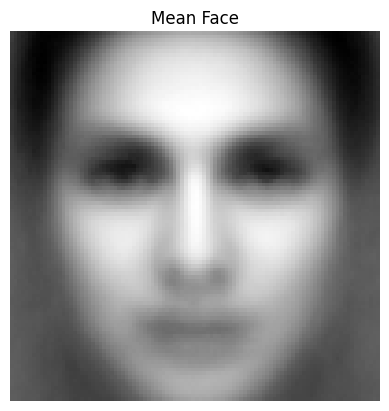

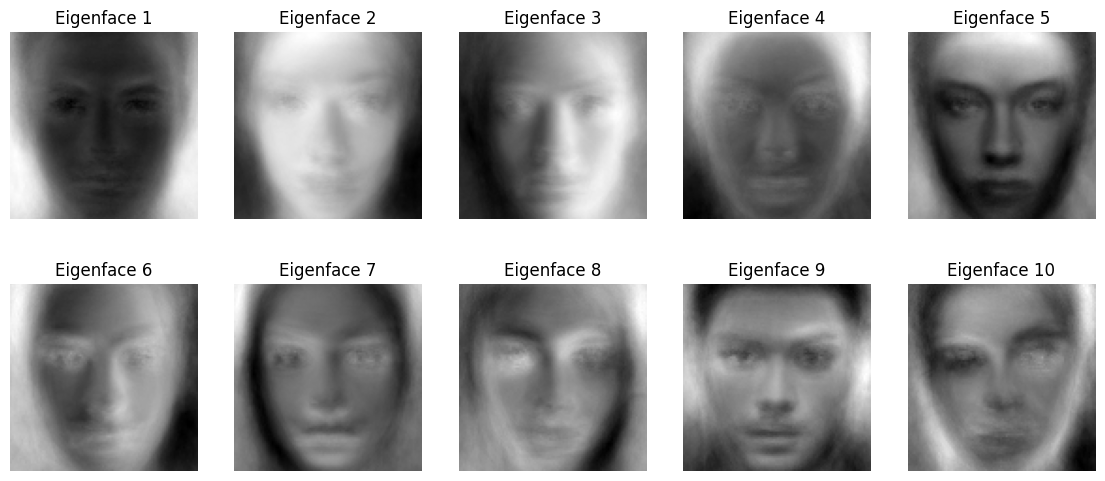

In [41]:
# ===============================
# 7. Visualizations (Optional)
# ===============================
h, w = IMG_SIZE

# Mean face
plt.imshow(mean_face.reshape(h, w), cmap="gray")
plt.title("Mean Face")
plt.axis("off")
plt.show()

# First 10 eigenfaces
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(h, w), cmap="gray")
    ax.set_title(f"Eigenface {i+1}")
    ax.axis("off")
plt.show()


In [42]:
# ===============================
# 8. Train SVM (Gender Classifier)
# ===============================
model = SVC(
    C=100,
    kernel="rbf",
    gamma=0.01,
    probability=True
)

model.fit(X_train_pca, y_train)


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",100
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",0.01
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [43]:
# ===============================
# 9. Evaluation (HONEST)
# ===============================
y_pred = model.predict(X_test_pca)

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       362
           1       0.97      0.99      0.98       400

    accuracy                           0.98       762
   macro avg       0.98      0.98      0.98       762
weighted avg       0.98      0.98      0.98       762

Confusion Matrix:
 [[350  12]
 [  4 396]]


In [44]:
# ===============================
# 10. Save Model (Production Ready)
# ===============================
bundle = {
    "mean_face": mean_face,
    "pca": pca,
    "svm": model,
    "img_size": IMG_SIZE
}

with open("gender_face_model_tuned2.pkl", "wb") as f:
    pickle.dump(bundle, f)

print("Model saved as gender_face_model.pkl")


Model saved as gender_face_model.pkl


In [24]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt



In [25]:
y_proba = model.predict_proba(X_test_pca)[:, 1]  # probability for class 1 (Female)


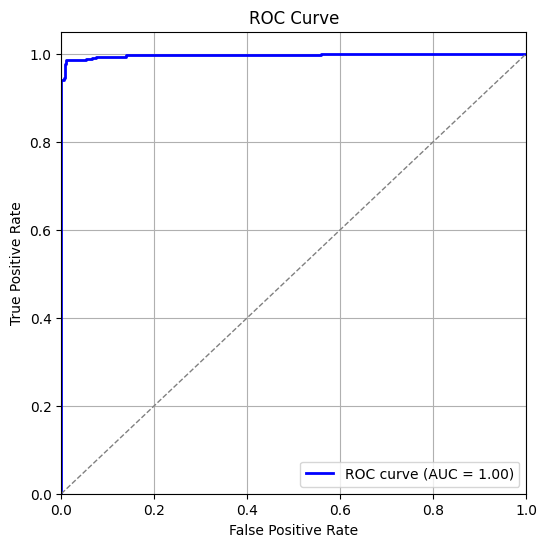

AUC: 0.9970511049723757


In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("AUC:", roc_auc)


<Figure size 600x600 with 0 Axes>

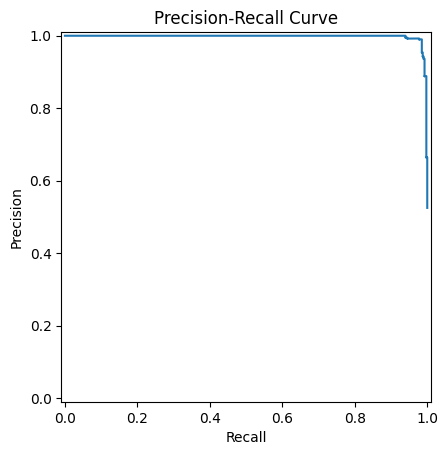

In [27]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()


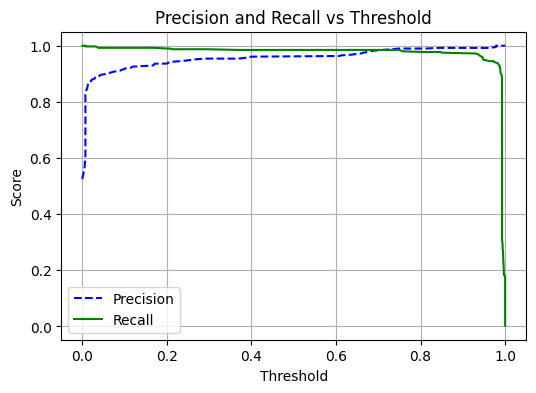

In [28]:
plt.figure(figsize=(6,4))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


In [30]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}


In [31]:
grid = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)


In [32]:
grid.fit(X_train_pca, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",SVC(probability=True)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.1, 1, ...], 'gamma': [0.001, 0.01, ...], 'kernel': ['rbf']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed

In [33]:
print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)


Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.9842364532019705


In [34]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_pca)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       362
           1       0.97      0.99      0.98       400

    accuracy                           0.98       762
   macro avg       0.98      0.98      0.98       762
weighted avg       0.98      0.98      0.98       762

Confusion Matrix:
 [[350  12]
 [  4 396]]


In [35]:
bundle = {
    "mean_face": mean_face,
    "pca": pca,
    "svm": best_model,
    "img_size": IMG_SIZE
}

with open("gender_face_model_tuned1.pkl", "wb") as f:
    pickle.dump(bundle, f)

print("Tuned model saved as gender_face_model_tuned.pkl")


Tuned model saved as gender_face_model_tuned.pkl
